In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import get_fr

# Examining mean population FR during caching

### i. Specify parameters to make plots

In [2]:
window = int(20*10)
fr_smoothing_window = int(20*0.5)
l2_normalization = False

### ii. Collect hop-centered activity for each hop

In [3]:
labeled_hops = {}
for key in h5_path_dict.keys():
    for fil in range(len(h5_path_dict[key])):
        fil_string = h5_path_dict[key][fil].as_posix()
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f)
        labeled_hops[fil_string] = {}
        c_hops, r_hops, noncr_hops = exp_data.get_cr_hops()
        hop_windows = exp_data.get_hop_windows(window)
        fr = get_fr(exp_data.spikes, fr_smoothing_window)
        if l2_normalization:
            scaling = np.square(np.linalg.norm(fr, axis=1))
            #scaling = np.linalg.norm(fr, axis=1)
            fr /= scaling[:, None]
        hop_patterns = np.zeros(
            (hop_windows.shape[0], exp_data.num_neurs, window*2 + 1)
            )
        for i, hop in enumerate(hop_windows):
            hop_pattern = fr[:, hop]
            hop_pattern[:, hop == -1] = np.nan
            hop_patterns[i] = hop_pattern            
        labeled_hops[fil_string]['c_hops'] = c_hops
        labeled_hops[fil_string]['r_hops'] = r_hops
        labeled_hops[fil_string]['noncr_hops'] = noncr_hops
        labeled_hops[fil_string]['fr'] = fr
        labeled_hops[fil_string]['hop_patterns'] = hop_patterns
        labeled_hops[fil_string]['hop_times'] = hop_windows

### iii. Plot mean population FR around the hop start

In [4]:
with open(pickle_dir / 'place_cells_1d.p', 'rb') as f: 
    all_place_cells = pickle.load(f)

In [5]:
with open(pickle_dir / 'episode_cells_overlap.p', 'rb') as f: 
    all_ep_cells = pickle.load(f)

In [6]:
# Collect mean firing rates
frames = np.empty(0)
frames_pl = np.empty(0)
frames_ep = np.empty(0)
mean_frs = np.empty(0)
mean_pl_frs = np.empty(0)
mean_ep_frs = np.empty(0)
hop_types = np.empty(0)
hop_types_pl = np.empty(0)
hop_types_ep = np.empty(0)
for fil_string in labeled_hops.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = labeled_hops[fil_string]['c_hops']
    r_hops = labeled_hops[fil_string]['r_hops']
    noncr_hops = labeled_hops[fil_string]['noncr_hops']
    hop_activity = labeled_hops[fil_string]['hop_patterns']
    pl_sig = all_place_cells[fil_string]['significance']
    ep_sig = all_ep_cells[fil_string]['significance']
    pl_only = np.logical_and(pl_sig, np.logical_not(ep_sig))
    ep_only = np.logical_and(ep_sig, np.logical_not(pl_sig))
    for idx, activity in enumerate(hop_activity):
        num_neurs, num_frames = activity.shape
        mean_fr = np.nanmean(activity, axis=0)
        mean_pl_fr = np.nanmean(activity[pl_only, :], axis=0)
        mean_ep_fr = np.nanmean(activity[ep_only, :], axis=0)
        nonnan_frames = np.argwhere(
            np.logical_not(np.isnan(mean_fr))
            ).squeeze()
        nonnan_pl_frames = np.argwhere(
            np.logical_not(np.isnan(mean_pl_fr))
            ).squeeze()
        nonnan_ep_frames = np.argwhere(
            np.logical_not(np.isnan(mean_ep_fr))
            ).squeeze()
        if idx in c_hops:
            hop_type = ["C"]
        elif idx in r_hops:
            hop_type = ["R"]
        else:
            hop_type = ["N"]
        frames = np.concatenate((frames, nonnan_frames))
        frames_pl = np.concatenate((frames, nonnan_pl_frames))
        frames_ep = np.concatenate((frames, nonnan_ep_frames))
        mean_frs = np.concatenate((mean_frs, mean_fr[nonnan_frames]))
        mean_pl_frs =np.concatenate((mean_pl_frs, mean_pl_fr[nonnan_pl_frames]))
        mean_ep_frs =np.concatenate((mean_ep_frs, mean_ep_fr[nonnan_ep_frames]))
        hop_types = np.concatenate((hop_types, hop_type*nonnan_frames.size))
        hop_types_pl = np.concatenate((hop_types, hop_type*nonnan_pl_frames.size))
        hop_types_ep = np.concatenate((hop_types, hop_type*nonnan_ep_frames.size))

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


(0, 0.04)

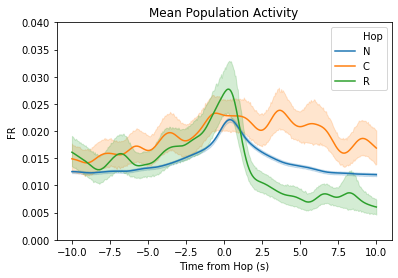

In [7]:
df = pd.DataFrame({
    "Frames": (frames - window)/20, "FR": mean_frs, "Hop": hop_types
    })
sns.lineplot(x="Frames", y="FR", hue="Hop", data=df)
plt.xlabel("Time from Hop (s)")
plt.title("Mean Population Activity")
plt.ylim(0, 0.04)

### iii. Plot mean place-only FR around the hop into a hop

(0, 0.04)

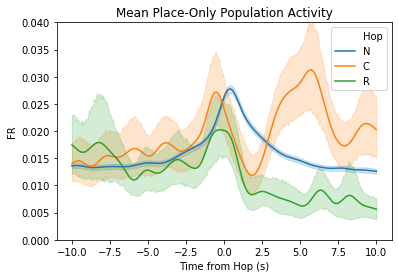

In [8]:
df = pd.DataFrame({
    "Frames": (frames - window)/20, "FR": mean_pl_frs, "Hop": hop_types
    })
sns.lineplot(x="Frames", y="FR", hue="Hop", data=df)
plt.xlabel("Time from Hop (s)")
plt.title("Mean Place-Only Population Activity")
plt.ylim(0, 0.04)

### iii. Plot mean episode-only FR around the hop into a hop

In [ ]:
df = pd.DataFrame({
    "Frames": (frames - window)/20, "FR": mean_ep_frs, "Hop": hop_types
    })
sns.lineplot(x="Frames", y="FR", hue="Hop", data=df)
plt.xlabel("Time from Hop (s)")
plt.title("Mean Episode-Only Population Activity")